In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the dataset (update path if needed)
df = pd.read_csv('mindx test dataset.csv')

print(f"Dataset loaded: {df.shape[0]} rows")
display(df.head())


Dataset loaded: 1440 rows


,ship_id,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,NG001,Oil Service Boat,Warri-Bonny,January,132.26,HFO,3779.77,10625.76,Stormy,92.14
1,NG001,Oil Service Boat,Port Harcourt-Lagos,February,128.52,HFO,4461.44,12779.73,Moderate,92.98
2,NG001,Oil Service Boat,Port Harcourt-Lagos,March,67.30,HFO,1867.73,5353.01,Calm,87.61
3,NG001,Oil Service Boat,Port Harcourt-Lagos,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42
4,NG001,Oil Service Boat,Lagos-Apapa,May,134.32,HFO,4267.19,11617.03,Calm,85.61


In [2]:
# Fleet-wide calculations
total_co2 = df['CO2_emissions'].sum()
total_distance = df['distance'].sum()
average_intensity = total_co2 / total_distance
target_intensity = average_intensity * 0.95  # 5% lower for 2026

# Per-vessel summary
vessel_summary = df.groupby('ship_id').agg(
    total_distance=('distance', 'sum'),
    total_co2=('CO2_emissions', 'sum'),
    ship_type=('ship_type', 'first')
).reset_index()

vessel_summary['intensity'] = vessel_summary['total_co2'] / vessel_summary['total_distance']

# Penalty risk levels
def get_risk_level(intensity, target):
    if intensity < target:
        return 'Surplus (No Risk)'
    deviation = intensity / target
    if deviation <= 1.05:
        return 'Deficit Low'
    elif deviation <= 1.1:
        return 'Deficit Medium'
    else:
        return 'Deficit High'

vessel_summary['risk_level'] = vessel_summary['intensity'].apply(get_risk_level, args=(target_intensity,))

# Financials (assume $100/kg excess CO2 penalty)
penalty_rate = 100  # $/kg excess
vessel_summary['excess_co2'] = np.maximum(0, (vessel_summary['intensity'] - target_intensity) * vessel_summary['total_distance'])
vessel_summary['est_penalty'] = vessel_summary['excess_co2'] * penalty_rate

# Separate Surplus/Deficit
surplus_ships = vessel_summary[vessel_summary['risk_level'] == 'Surplus (No Risk)']['ship_id'].tolist()
deficit_ships = vessel_summary[vessel_summary['risk_level'] != 'Surplus (No Risk)']['ship_id'].tolist()

print(f"Target Intensity: {target_intensity:.2f} kg CO₂/unit")
display(vessel_summary.head())

Target Intensity: 83.67 kg CO₂/unit


,ship_id,total_distance,total_co2,ship_type,intensity,risk_level,excess_co2,est_penalty
0,NG001,1169.77,98085.59,Oil Service Boat,83.850321,Deficit Low,211.096016,2.110960e+04
1,NG002,1686.12,119531.19,Fishing Trawler,70.891271,Surplus (No Risk),0.000000,0.000000e+00
2,NG003,1013.77,83470.50,Oil Service Boat,82.336723,Surplus (No Risk),0.000000,0.000000e+00
3,NG004,1498.23,57087.30,Surfer Boat,38.103162,Surplus (No Risk),0.000000,0.000000e+00
4,NG005,3298.95,375496.06,Tanker Ship,113.822901,Deficit High,99473.370131,9.947337e+06


C:\Users\MOHAMED NAVEETH\AppData\Local\Temp\ipykernel_29272\1225853778.py:21: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: f'background-color: {risk_colors.get(x, "white")}', subset=['risk_level'])


,ship_id,total_distance,total_co2,ship_type,intensity,risk_level,excess_co2,est_penalty
60,NG061,1473.43,54643.75,Surfer Boat,37.09,Surplus (No Risk),0.00,$0
12,NG013,1197.84,44925.79,Surfer Boat,37.51,Surplus (No Risk),0.00,$0
3,NG004,1498.23,57087.30,Surfer Boat,38.10,Surplus (No Risk),0.00,$0
33,NG034,1373.27,53090.74,Surfer Boat,38.66,Surplus (No Risk),0.00,$0
27,NG028,1547.61,59862.87,Surfer Boat,38.68,Surplus (No Risk),0.00,$0
109,NG110,1209.03,47445.17,Surfer Boat,39.24,Surplus (No Risk),0.00,$0
46,NG047,1033.81,40627.37,Surfer Boat,39.30,Surplus (No Risk),0.00,$0
110,NG111,1609.12,63731.85,Surfer Boat,39.61,Surplus (No Risk),0.00,$0
87,NG088,1658.47,66552.34,Surfer Boat,40.13,Surplus (No Risk),0.00,$0
77,NG078,1184.77,47722.17,Surfer Boat,40.28,Surplus (No Risk),0.00,$0


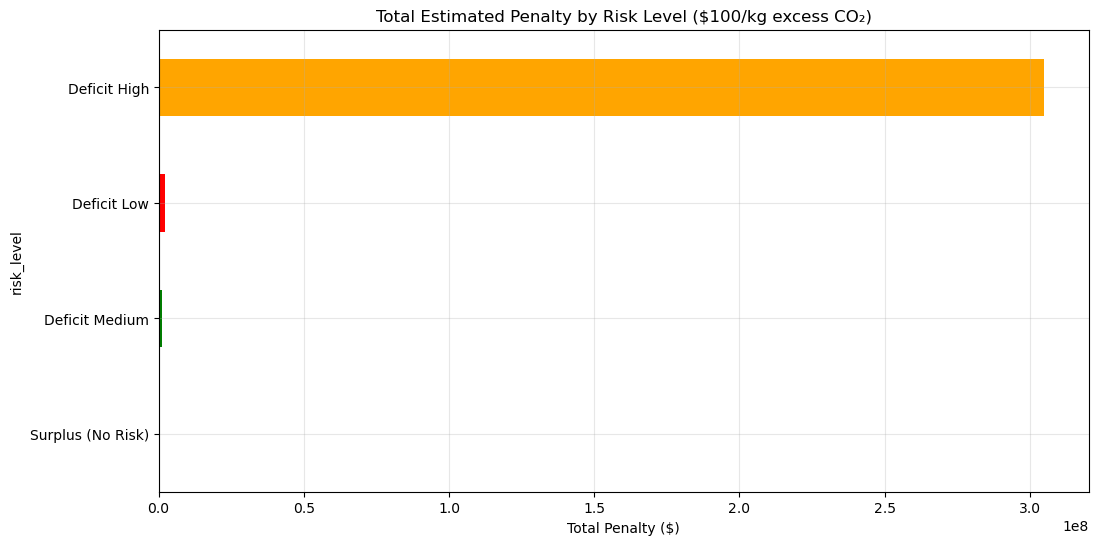

In [3]:
# Color mapping for risk levels
risk_colors = {
    'Surplus (No Risk)': 'green',
    'Deficit Low': 'lightyellow',
    'Deficit Medium': 'orange',
    'Deficit High': 'red'
}

# Create styled table
styled_table = (vessel_summary
                .sort_values('intensity')
                .style
                .background_gradient(subset=['intensity'], cmap='RdYlGn_r')
                .format({
                    'total_distance': '{:.2f}',
                    'total_co2': '{:.2f}',
                    'intensity': '{:.2f}',
                    'excess_co2': '{:.2f}',
                    'est_penalty': '${:,.0f}'
                })
                .applymap(lambda x: f'background-color: {risk_colors.get(x, "white")}', subset=['risk_level'])
                .set_caption("<h2>Liability Map: Vessel Compliance & Penalty Risk</h2>")
               )

# Display the table
display(styled_table)

# Bar chart: Total estimated penalty by risk level
plt.figure(figsize=(12, 6))
ax = vessel_summary.groupby('risk_level')['est_penalty'].sum().sort_values().plot(
    kind='barh', 
    color=[risk_colors.get(r, 'gray') for r in vessel_summary['risk_level'].unique()]
)
ax.set_title('Total Estimated Penalty by Risk Level ($100/kg excess CO₂)')
ax.set_xlabel('Total Penalty ($)')
ax.grid(True, alpha=0.3)
plt.show()

In [4]:
# Dropdowns and button
deficit_dropdown = widgets.Dropdown(
    options=deficit_ships,
    description='Deficit Ship:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

surplus_dropdown = widgets.Dropdown(
    options=surplus_ships,
    description='Surplus Ship:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

simulate_button = widgets.Button(
    description='Simulate Pooling',
    button_style='success',
    layout=widgets.Layout(width='200px')
)

output = widgets.Output()

def on_simulate_clicked(b):
    with output:
        clear_output()
        if not deficit_dropdown.value or not surplus_dropdown.value:
            print("⚠️ Please select both a Deficit and a Surplus ship.")
            return
        
        # Get data for selected ships
        deficit_data = vessel_summary[vessel_summary['ship_id'] == deficit_dropdown.value].iloc[0]
        surplus_data = vessel_summary[vessel_summary['ship_id'] == surplus_dropdown.value].iloc[0]
        
        combined_distance = deficit_data['total_distance'] + surplus_data['total_distance']
        combined_co2 = deficit_data['total_co2'] + surplus_data['total_co2']
        combined_intensity = combined_co2 / combined_distance
        
        if combined_intensity <= target_intensity:
            status = "✅ Offsets to Zero or Surplus!"
            remaining_excess = 0
        else:
            status = "⚠️ Remaining Deficit"
            remaining_excess = (combined_intensity - target_intensity) * combined_distance
        
        potential_savings = max(0, deficit_data['excess_co2'] * penalty_rate - remaining_excess * penalty_rate)
        
        print(f"🚢 Deficit Ship: {deficit_data['ship_id']} ({deficit_data['ship_type']})")
        print(f"   Intensity: {deficit_data['intensity']:.2f} | Excess CO₂: {deficit_data['excess_co2']:.0f} kg | Penalty: ${deficit_data['est_penalty']:,.0f}\n")
        
        print(f"🚢 Surplus Ship: {surplus_data['ship_id']} ({surplus_data['ship_type']})")
        print(f"   Intensity: {surplus_data['intensity']:.2f} | Surplus capacity: {-surplus_data['excess_co2']:.0f} kg\n")
        
        print(f"📊 Combined Intensity: {combined_intensity:.2f} kg CO₂/unit (Target: {target_intensity:.2f})")
        print(f"   {status}")
        print(f"💰 Potential Penalty Savings: ${potential_savings:,.0f}")

simulate_button.on_click(on_simulate_clicked)

# Display the simulator neatly
simulator_ui = widgets.VBox([
    widgets.HTML("<h2>🛠 Pooling Simulator</h2><p>Select one Deficit and one Surplus ship to see if pooling offsets the penalty.</p>"),
    deficit_dropdown,
    surplus_dropdown,
    simulate_button,
    output
])

display(simulator_ui)